In [ ]:
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import keras
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPool2D, AveragePooling2D, Input, BatchNormalization, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.models import Model
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing import image
import scipy
import os
import cv2
from tensorflow.keras.callbacks import EarlyStopping
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/fer2013.csv')
data.head()

pixel_data = data['pixels']
label_data = data['emotion']

In [ ]:
def expand_greyscale_image_channels(grey_image):
    grey_image_arr = np.array(grey_image)
    grey_image_arr = np.expand_dims(grey_image_arr, -1)
    grey_image_arr_3_channel = grey_image_arr.repeat(3, axis=-1)
    return grey_image_arr_3_channel

In [ ]:
def preprocess_pixels(pixel_data):
  images = []
  for i in range(len(pixel_data)):
    img = np.fromstring(pixel_data[i], dtype='int', sep=' ')
    img = img.reshape(48,48)
    img = expand_greyscale_image_channels(img)
    images.append(img)

  X = np.array(images)

 

  return X

In [ ]:
oversampler = RandomOverSampler(sampling_strategy='auto')

X_over, Y_over = oversampler.fit_resample(pixel_data.values.reshape(-1,1), label_data)

X_over_series = pd.Series(X_over.flatten())

In [ ]:
X = preprocess_pixels(X_over_series)
Y = Y_over
Y = Y.values.reshape(-1,1)

In [ ]:
print("Images shape = ",X.shape,"\nLabels shape = ",Y.shape)
print(type(X),type(Y))

Images shape =  (62923, 48, 48, 3) 
Labels shape =  (62923, 1)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


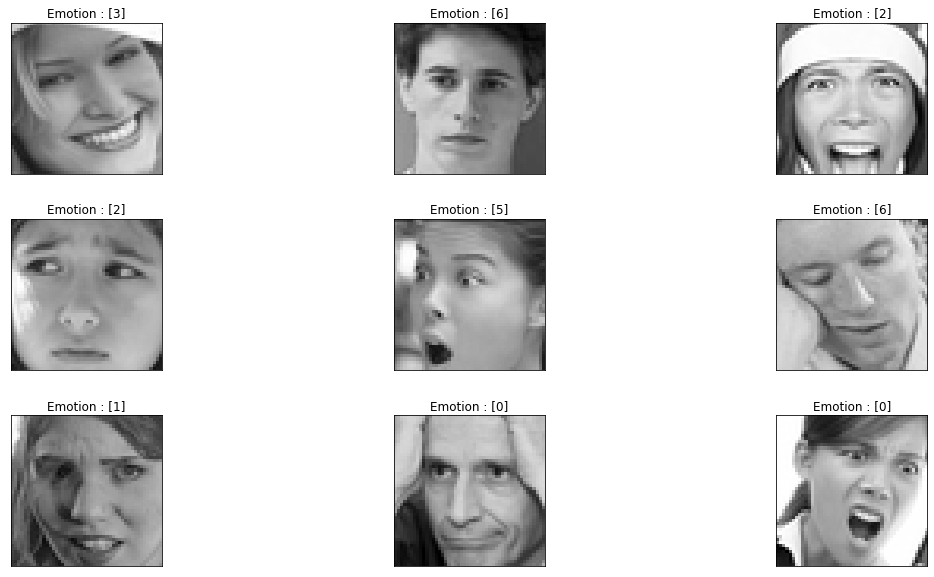

In [ ]:
def display_rand_images(images, labels):
    
    plt.figure(1 , figsize = (19 , 10))
    n = 0 
    for i in range(9):
        n += 1 
        r = np.random.randint(0 , images.shape[0] , 1)
        
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[r[0]])
        
        plt.title('Emotion : {}'.format(labels[r[0]]))
        plt.xticks([])
        plt.yticks([])
        
    plt.show()
    
display_rand_images(X, Y)
#0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

In [ ]:
#1-step in data shuffling

#get equally spaced numbers in a given range
n = np.arange(X.shape[0])
print("'n' values before shuffling = ",n)

#shuffle all the equally spaced values in list 'n'
np.random.seed(45)
np.random.shuffle(n)
print("\n'n' values after shuffling = ",n)

'n' values before shuffling =  [    0     1     2 ... 62920 62921 62922]

'n' values after shuffling =  [62634  6425 11709 ...  6012  6558 56267]


In [ ]:
#2-step in data shuffling

#shuffle images and corresponding labels data in both the lists
X = X[n]
Y = Y[n]

print("Images shape after shuffling = ",X.shape,"\nLabels shape after shuffling = ",Y.shape)

Images shape after shuffling =  (62923, 48, 48, 3) 
Labels shape after shuffling =  (62923, 1)


In [ ]:
X = X.astype(np.float32)
Y = Y.astype(np.int32)
X = X/255
print("Images shape after normalization = ",X.shape)

Images shape after normalization =  (62923, 48, 48, 3)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 45)

X_val = X_train[:12585]
Y_val = Y_train[:12585]
X_train = X_train[12585:]
Y_train = Y_train[12585:]

print("x_train shape = ",X_train.shape)
print("y_train shape = ",Y_train.shape)
print("\nx_test shape = ",X_test.shape)
print("y_test shape = ",Y_test.shape)

print("\nx_val shape = ",X_val.shape)
print("y_val shape = ",Y_val.shape)

x_train shape =  (37753, 48, 48, 3)
y_train shape =  (37753, 1)

x_test shape =  (12585, 48, 48, 3)
y_test shape =  (12585, 1)

x_val shape =  (12585, 48, 48, 3)
y_val shape =  (12585, 1)


In [ ]:
y_train = to_categorical(Y_train, num_classes=7)
y_test = to_categorical(Y_test, num_classes=7)
y_val = to_categorical(Y_val, num_classes=7)

In [ ]:
y_train.shape, y_test.shape, y_val.shape

((37753, 7), (12585, 7), (12585, 7))

In [ ]:
pre_trained_model = tf.keras.applications.VGG16(input_shape=X_train[0].shape, include_top=False, weights="imagenet")

In [ ]:
model = tf.keras.models.Sequential()

model.add(pre_trained_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(7, activation='softmax'))

In [ ]:
pre_trained_model.trainable = True
set_trainable = False
for layer in pre_trained_model.layers:
    print(layer.name)
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 14,980,935
Trainable params: 7,345,671
Non-trainable params: 7,635,264
_________________________________________________________________


In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [ ]:
X_train.shape,y_train.shape

((37753, 48, 48, 3), (37753, 7))

In [ ]:
start_time = time.time()

history = model.fit(X_train, y_train,
    epochs = 15,
    validation_data=(X_val, y_val),
    callbacks=[es],
    verbose=1)

print("Training Execution Time:" + time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))

Epoch 1/15
1180/1180 [==============================] - 1693s 1s/step - loss: 1.3442 - accuracy: 0.4911 - val_loss: 1.1613 - val_accuracy: 0.5501
Epoch 2/15
1180/1180 [==============================] - 1706s 1s/step - loss: 0.9722 - accuracy: 0.6354 - val_loss: 0.9901 - val_accuracy: 0.6266
Epoch 3/15
1180/1180 [==============================] - 1709s 1s/step - loss: 0.7577 - accuracy: 0.7223 - val_loss: 0.8711 - val_accuracy: 0.6890
Epoch 4/15
1180/1180 [==============================] - 1723s 1s/step - loss: 0.5472 - accuracy: 0.8065 - val_loss: 0.8666 - val_accuracy: 0.7086
Epoch 5/15
1180/1180 [==============================] - 1719s 1s/step - loss: 0.3770 - accuracy: 0.8696 - val_loss: 0.9128 - val_accuracy: 0.7332
Epoch 6/15
1180/1180 [==============================] - 1719s 1s/step - loss: 0.2531 - accuracy: 0.9143 - val_loss: 0.8884 - val_accuracy: 0.7544
Epoch 7/15
1180/1180 [==============================] - 1726s 1s/step - loss: 0.1747 - accuracy: 0.9426 - val_loss: 0.9876 -

In [ ]:
loss, accuracy = model.evaluate(X_test,y_test)
print('test_loss: %.2f' % (loss * 100.0))  
print('test_accuracy: %.2f' % (accuracy * 100.0))

394/394 [==============================] - 311s 789ms/step - loss: 1.2376 - accuracy: 0.7794
test_loss: 123.76
test_accuracy: 77.94


In [ ]:
model_probs = model.predict(X_test,verbose=0)
# predict crisp classes for test set
model_classes = np.argmax(model_probs,axis=1)
# reduce to 1d array
model_probs = model_probs[:, 0]

y_test_reduced = np.argmax(y_test,axis=1)
 
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_reduced, model_classes)*100
# precision tp / (tp + fp)
precision = precision_score(y_test_reduced, model_classes, average='weighted')*100
# recall: tp / (tp + fn)
recall = recall_score(y_test_reduced, model_classes, average='weighted')*100
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_reduced, model_classes, average='weighted')*100

print('Accuracy: %.2f' % accuracy)
print('F1 score: %.2f' % f1)
print('Precision: %.2f' % precision)
print('Recall: %.2f' % recall)

Accuracy: 77.94
F1 score: 77.93
Precision: 78.04
Recall: 77.94
